In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b10','b25','b50','b75'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_CCE_10_1_1_0_1_0_e_e_0_1_1_connectivity_data_norm_b10_b25_b50_b75_roi_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_t1_0_42_n_native_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1919620, 750)
(1919620, 8)
validation
(288502, 750)
(288502, 8)
test
(221128, 750)
(221128, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 750)]             0         


 dense (Dense)               (None, 2048)              1538048   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 4326280 (16.50 MB)


Trainable params: 4326280 (16.50 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


 1/20 [>.............................] - ETA: 3:23 - loss: 2.1372 - STD: 0.0359 - MAE: 0.2189

 2/20 [==>...........................] - ETA: 7s - loss: 2.1108 - STD: 0.0259 - MAE: 0.2188  

 3/20 [===>..........................] - ETA: 7s - loss: 2.1046 - STD: 0.0257 - MAE: 0.2187

 4/20 [=====>........................] - ETA: 6s - loss: 2.1037 - STD: 0.0268 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 5s - loss: 2.1018 - STD: 0.0264 - MAE: 0.2186

 6/20 [========>.....................] - ETA: 5s - loss: 2.0990 - STD: 0.0247 - MAE: 0.2186

 7/20 [=========>....................] - ETA: 5s - loss: 2.0961 - STD: 0.0223 - MAE: 0.2186

 8/20 [===========>..................] - ETA: 4s - loss: 2.0940 - STD: 0.0208 - MAE: 0.2186

 9/20 [============>.................] - ETA: 4s - loss: 2.0929 - STD: 0.0201 - MAE: 0.2186

10/20 [==============>...............] - ETA: 4s - loss: 2.0922 - STD: 0.0196 - MAE: 0.2187

11/20 [===============>..............] - ETA: 3s - loss: 2.0916 - STD: 0.0192 - MAE: 0.2187

12/20 [=================>............] - ETA: 3s - loss: 2.0909 - STD: 0.0186 - MAE: 0.2187

13/20 [==================>...........] - ETA: 4s - loss: 2.0907 - STD: 0.0178 - MAE: 0.2187

14/20 [====================>.........] - ETA: 3s - loss: 2.0898 - STD: 0.0170 - MAE: 0.2187

15/20 [=====================>........] - ETA: 2s - loss: 2.0889 - STD: 0.0163 - MAE: 0.2187

16/20 [=======================>......] - ETA: 2s - loss: 2.0883 - STD: 0.0160 - MAE: 0.2187

17/20 [========================>.....] - ETA: 1s - loss: 2.0877 - STD: 0.0158 - MAE: 0.2187

18/20 [==========================>...] - ETA: 1s - loss: 2.0872 - STD: 0.0157 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.0867 - STD: 0.0155 - MAE: 0.2186

20/20 [==============================] - ETA: 0s - loss: 2.0862 - STD: 0.0154 - MAE: 0.2186

20/20 [==============================] - 26s 799ms/step - loss: 2.0862 - STD: 0.0154 - MAE: 0.2186 - val_loss: 2.0736 - val_STD: 0.0100 - val_MAE: 0.2185


Epoch 2/10000


 1/20 [>.............................] - ETA: 15s - loss: 2.0755 - STD: 0.0100 - MAE: 0.2185

 2/20 [==>...........................] - ETA: 7s - loss: 2.0743 - STD: 0.0089 - MAE: 0.2185 

 3/20 [===>..........................] - ETA: 7s - loss: 2.0734 - STD: 0.0082 - MAE: 0.2185

 4/20 [=====>........................] - ETA: 6s - loss: 2.0724 - STD: 0.0079 - MAE: 0.2185

 5/20 [======>.......................] - ETA: 6s - loss: 2.0714 - STD: 0.0080 - MAE: 0.2184

 6/20 [========>.....................] - ETA: 5s - loss: 2.0700 - STD: 0.0082 - MAE: 0.2184

 7/20 [=========>....................] - ETA: 5s - loss: 2.0683 - STD: 0.0086 - MAE: 0.2183

 8/20 [===========>..................] - ETA: 4s - loss: 2.0660 - STD: 0.0089 - MAE: 0.2182

 9/20 [============>.................] - ETA: 4s - loss: 2.0631 - STD: 0.0094 - MAE: 0.2181

10/20 [==============>...............] - ETA: 4s - loss: 2.0594 - STD: 0.0101 - MAE: 0.2180

11/20 [===============>..............] - ETA: 3s - loss: 2.0550 - STD: 0.0110 - MAE: 0.2178

12/20 [=================>............] - ETA: 3s - loss: 2.0498 - STD: 0.0123 - MAE: 0.2176

13/20 [==================>...........] - ETA: 2s - loss: 2.0441 - STD: 0.0139 - MAE: 0.2174

14/20 [====================>.........] - ETA: 2s - loss: 2.0381 - STD: 0.0159 - MAE: 0.2171

15/20 [=====================>........] - ETA: 1s - loss: 2.0321 - STD: 0.0179 - MAE: 0.2168

16/20 [=======================>......] - ETA: 1s - loss: 2.0257 - STD: 0.0201 - MAE: 0.2164

17/20 [========================>.....] - ETA: 1s - loss: 2.0194 - STD: 0.0224 - MAE: 0.2160

18/20 [==========================>...] - ETA: 0s - loss: 2.0140 - STD: 0.0247 - MAE: 0.2157

19/20 [===========================>..] - ETA: 0s - loss: 2.0129 - STD: 0.0272 - MAE: 0.2153

20/20 [==============================] - ETA: 0s - loss: 2.0075 - STD: 0.0294 - MAE: 0.2150

20/20 [==============================] - 9s 440ms/step - loss: 2.0075 - STD: 0.0294 - MAE: 0.2150 - val_loss: 1.9423 - val_STD: 0.0724 - val_MAE: 0.2092


Epoch 3/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.9129 - STD: 0.0739 - MAE: 0.2080

 2/20 [==>...........................] - ETA: 9s - loss: 1.9040 - STD: 0.0762 - MAE: 0.2075

 3/20 [===>..........................] - ETA: 7s - loss: 1.9017 - STD: 0.0762 - MAE: 0.2075

 4/20 [=====>........................] - ETA: 7s - loss: 1.8997 - STD: 0.0761 - MAE: 0.2074

 5/20 [======>.......................] - ETA: 6s - loss: 1.8982 - STD: 0.0766 - MAE: 0.2073

 6/20 [========>.....................] - ETA: 6s - loss: 1.8957 - STD: 0.0763 - MAE: 0.2073

 7/20 [=========>....................] - ETA: 5s - loss: 1.8939 - STD: 0.0759 - MAE: 0.2073

 8/20 [===========>..................] - ETA: 5s - loss: 1.8921 - STD: 0.0759 - MAE: 0.2073

 9/20 [============>.................] - ETA: 4s - loss: 1.8901 - STD: 0.0756 - MAE: 0.2073

10/20 [==============>...............] - ETA: 4s - loss: 1.8887 - STD: 0.0754 - MAE: 0.2073

11/20 [===============>..............] - ETA: 3s - loss: 1.8873 - STD: 0.0756 - MAE: 0.2072

12/20 [=================>............] - ETA: 3s - loss: 1.8857 - STD: 0.0755 - MAE: 0.2072

13/20 [==================>...........] - ETA: 2s - loss: 1.8842 - STD: 0.0755 - MAE: 0.2071

14/20 [====================>.........] - ETA: 2s - loss: 1.8831 - STD: 0.0757 - MAE: 0.2071

15/20 [=====================>........] - ETA: 2s - loss: 1.8821 - STD: 0.0756 - MAE: 0.2071

16/20 [=======================>......] - ETA: 1s - loss: 1.8808 - STD: 0.0757 - MAE: 0.2070

17/20 [========================>.....] - ETA: 1s - loss: 1.8795 - STD: 0.0757 - MAE: 0.2070

18/20 [==========================>...] - ETA: 0s - loss: 1.8782 - STD: 0.0757 - MAE: 0.2070

19/20 [===========================>..] - ETA: 0s - loss: 1.8768 - STD: 0.0758 - MAE: 0.2069

20/20 [==============================] - ETA: 0s - loss: 1.8753 - STD: 0.0759 - MAE: 0.2068

20/20 [==============================] - 9s 482ms/step - loss: 1.8753 - STD: 0.0759 - MAE: 0.2068 - val_loss: 1.8900 - val_STD: 0.0764 - val_MAE: 0.2072


Epoch 4/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.8488 - STD: 0.0776 - MAE: 0.2058

 2/20 [==>...........................] - ETA: 8s - loss: 1.8472 - STD: 0.0796 - MAE: 0.2054 

 3/20 [===>..........................] - ETA: 7s - loss: 1.8451 - STD: 0.0796 - MAE: 0.2053

 4/20 [=====>........................] - ETA: 7s - loss: 1.8440 - STD: 0.0800 - MAE: 0.2052

 5/20 [======>.......................] - ETA: 5s - loss: 1.8436 - STD: 0.0806 - MAE: 0.2051

 6/20 [========>.....................] - ETA: 5s - loss: 1.8425 - STD: 0.0808 - MAE: 0.2050

 7/20 [=========>....................] - ETA: 4s - loss: 1.8413 - STD: 0.0814 - MAE: 0.2049

 8/20 [===========>..................] - ETA: 4s - loss: 1.8395 - STD: 0.0816 - MAE: 0.2048

 9/20 [============>.................] - ETA: 4s - loss: 1.8377 - STD: 0.0819 - MAE: 0.2047

10/20 [==============>...............] - ETA: 3s - loss: 1.8359 - STD: 0.0821 - MAE: 0.2046

11/20 [===============>..............] - ETA: 3s - loss: 1.8341 - STD: 0.0822 - MAE: 0.2045

12/20 [=================>............] - ETA: 3s - loss: 1.8325 - STD: 0.0825 - MAE: 0.2044

13/20 [==================>...........] - ETA: 2s - loss: 1.8319 - STD: 0.0825 - MAE: 0.2044

14/20 [====================>.........] - ETA: 2s - loss: 1.8324 - STD: 0.0831 - MAE: 0.2043

15/20 [=====================>........] - ETA: 1s - loss: 1.8331 - STD: 0.0830 - MAE: 0.2043

16/20 [=======================>......] - ETA: 1s - loss: 1.8310 - STD: 0.0832 - MAE: 0.2042

17/20 [========================>.....] - ETA: 1s - loss: 1.8320 - STD: 0.0837 - MAE: 0.2042

18/20 [==========================>...] - ETA: 0s - loss: 1.8313 - STD: 0.0836 - MAE: 0.2042

19/20 [===========================>..] - ETA: 0s - loss: 1.8305 - STD: 0.0835 - MAE: 0.2042

20/20 [==============================] - ETA: 0s - loss: 1.8301 - STD: 0.0839 - MAE: 0.2041

20/20 [==============================] - 9s 456ms/step - loss: 1.8301 - STD: 0.0839 - MAE: 0.2041 - val_loss: 1.8329 - val_STD: 0.0871 - val_MAE: 0.2035


Epoch 5/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.7896 - STD: 0.0879 - MAE: 0.2020

 2/20 [==>...........................] - ETA: 6s - loss: 1.8027 - STD: 0.0856 - MAE: 0.2028 

 3/20 [===>..........................] - ETA: 6s - loss: 1.7962 - STD: 0.0858 - MAE: 0.2025

 4/20 [=====>........................] - ETA: 6s - loss: 1.8003 - STD: 0.0877 - MAE: 0.2024

 5/20 [======>.......................] - ETA: 6s - loss: 1.7958 - STD: 0.0877 - MAE: 0.2022

 6/20 [========>.....................] - ETA: 5s - loss: 1.7961 - STD: 0.0874 - MAE: 0.2022

 7/20 [=========>....................] - ETA: 4s - loss: 1.7955 - STD: 0.0878 - MAE: 0.2021

 8/20 [===========>..................] - ETA: 4s - loss: 1.7936 - STD: 0.0886 - MAE: 0.2019

 9/20 [============>.................] - ETA: 3s - loss: 1.7908 - STD: 0.0888 - MAE: 0.2017

10/20 [==============>...............] - ETA: 3s - loss: 1.7888 - STD: 0.0890 - MAE: 0.2016

11/20 [===============>..............] - ETA: 3s - loss: 1.7872 - STD: 0.0895 - MAE: 0.2015

12/20 [=================>............] - ETA: 2s - loss: 1.7854 - STD: 0.0899 - MAE: 0.2014

13/20 [==================>...........] - ETA: 2s - loss: 1.7841 - STD: 0.0900 - MAE: 0.2013

14/20 [====================>.........] - ETA: 2s - loss: 1.7817 - STD: 0.0904 - MAE: 0.2011

15/20 [=====================>........] - ETA: 1s - loss: 1.7805 - STD: 0.0908 - MAE: 0.2010

16/20 [=======================>......] - ETA: 1s - loss: 1.7786 - STD: 0.0910 - MAE: 0.2009

17/20 [========================>.....] - ETA: 1s - loss: 1.7769 - STD: 0.0913 - MAE: 0.2008

18/20 [==========================>...] - ETA: 0s - loss: 1.7755 - STD: 0.0917 - MAE: 0.2007

19/20 [===========================>..] - ETA: 0s - loss: 1.7739 - STD: 0.0920 - MAE: 0.2005

20/20 [==============================] - ETA: 0s - loss: 1.7723 - STD: 0.0922 - MAE: 0.2004

20/20 [==============================] - 9s 452ms/step - loss: 1.7723 - STD: 0.0922 - MAE: 0.2004 - val_loss: 1.7945 - val_STD: 0.0995 - val_MAE: 0.1995


Epoch 6/10000


 1/20 [>.............................] - ETA: 16s - loss: 1.7480 - STD: 0.1004 - MAE: 0.1979

 2/20 [==>...........................] - ETA: 7s - loss: 1.7413 - STD: 0.0991 - MAE: 0.1980 

 3/20 [===>..........................] - ETA: 6s - loss: 1.7390 - STD: 0.0987 - MAE: 0.1980

 4/20 [=====>........................] - ETA: 6s - loss: 1.7389 - STD: 0.0990 - MAE: 0.1979

 5/20 [======>.......................] - ETA: 5s - loss: 1.7398 - STD: 0.0986 - MAE: 0.1980

 6/20 [========>.....................] - ETA: 4s - loss: 1.7392 - STD: 0.0989 - MAE: 0.1979

 7/20 [=========>....................] - ETA: 4s - loss: 1.7364 - STD: 0.0992 - MAE: 0.1977

 8/20 [===========>..................] - ETA: 4s - loss: 1.7355 - STD: 0.0992 - MAE: 0.1977

 9/20 [============>.................] - ETA: 3s - loss: 1.7359 - STD: 0.0999 - MAE: 0.1976

10/20 [==============>...............] - ETA: 3s - loss: 1.7376 - STD: 0.0999 - MAE: 0.1977

11/20 [===============>..............] - ETA: 3s - loss: 1.7373 - STD: 0.1003 - MAE: 0.1976

12/20 [=================>............] - ETA: 2s - loss: 1.7350 - STD: 0.1003 - MAE: 0.1975

13/20 [==================>...........] - ETA: 2s - loss: 1.7326 - STD: 0.1004 - MAE: 0.1974

14/20 [====================>.........] - ETA: 2s - loss: 1.7310 - STD: 0.1007 - MAE: 0.1973

15/20 [=====================>........] - ETA: 1s - loss: 1.7322 - STD: 0.1008 - MAE: 0.1973

16/20 [=======================>......] - ETA: 1s - loss: 1.7327 - STD: 0.1012 - MAE: 0.1972

17/20 [========================>.....] - ETA: 1s - loss: 1.7319 - STD: 0.1013 - MAE: 0.1972

18/20 [==========================>...] - ETA: 0s - loss: 1.7298 - STD: 0.1015 - MAE: 0.1971

19/20 [===========================>..] - ETA: 0s - loss: 1.7280 - STD: 0.1017 - MAE: 0.1970

20/20 [==============================] - ETA: 0s - loss: 1.7276 - STD: 0.1018 - MAE: 0.1969

20/20 [==============================] - 9s 445ms/step - loss: 1.7276 - STD: 0.1018 - MAE: 0.1969 - val_loss: 1.7598 - val_STD: 0.1069 - val_MAE: 0.1968


Epoch 7/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.7100 - STD: 0.1084 - MAE: 0.1949

 2/20 [==>...........................] - ETA: 7s - loss: 1.6979 - STD: 0.1065 - MAE: 0.1949 

 3/20 [===>..........................] - ETA: 6s - loss: 1.6912 - STD: 0.1061 - MAE: 0.1948

 4/20 [=====>........................] - ETA: 6s - loss: 1.6891 - STD: 0.1066 - MAE: 0.1946

 5/20 [======>.......................] - ETA: 6s - loss: 1.6909 - STD: 0.1065 - MAE: 0.1947

 6/20 [========>.....................] - ETA: 5s - loss: 1.6901 - STD: 0.1068 - MAE: 0.1946

 7/20 [=========>....................] - ETA: 5s - loss: 1.6874 - STD: 0.1068 - MAE: 0.1945

 8/20 [===========>..................] - ETA: 4s - loss: 1.6838 - STD: 0.1071 - MAE: 0.1944

 9/20 [============>.................] - ETA: 4s - loss: 1.6810 - STD: 0.1074 - MAE: 0.1942

10/20 [==============>...............] - ETA: 4s - loss: 1.6794 - STD: 0.1077 - MAE: 0.1941

11/20 [===============>..............] - ETA: 3s - loss: 1.6785 - STD: 0.1080 - MAE: 0.1940

12/20 [=================>............] - ETA: 3s - loss: 1.6791 - STD: 0.1083 - MAE: 0.1940

13/20 [==================>...........] - ETA: 2s - loss: 1.6783 - STD: 0.1087 - MAE: 0.1939

14/20 [====================>.........] - ETA: 2s - loss: 1.6771 - STD: 0.1088 - MAE: 0.1938

15/20 [=====================>........] - ETA: 1s - loss: 1.6756 - STD: 0.1089 - MAE: 0.1937

16/20 [=======================>......] - ETA: 1s - loss: 1.6737 - STD: 0.1091 - MAE: 0.1936

17/20 [========================>.....] - ETA: 1s - loss: 1.6721 - STD: 0.1093 - MAE: 0.1935

18/20 [==========================>...] - ETA: 0s - loss: 1.6705 - STD: 0.1096 - MAE: 0.1934

19/20 [===========================>..] - ETA: 0s - loss: 1.6687 - STD: 0.1097 - MAE: 0.1933

20/20 [==============================] - ETA: 0s - loss: 1.6683 - STD: 0.1099 - MAE: 0.1932

20/20 [==============================] - 9s 455ms/step - loss: 1.6683 - STD: 0.1099 - MAE: 0.1932 - val_loss: 1.6838 - val_STD: 0.1129 - val_MAE: 0.1934


Epoch 8/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.6414 - STD: 0.1149 - MAE: 0.1913

 2/20 [==>...........................] - ETA: 6s - loss: 1.6402 - STD: 0.1151 - MAE: 0.1912 

 3/20 [===>..........................] - ETA: 6s - loss: 1.6381 - STD: 0.1140 - MAE: 0.1914

 4/20 [=====>........................] - ETA: 6s - loss: 1.6359 - STD: 0.1134 - MAE: 0.1914

 5/20 [======>.......................] - ETA: 6s - loss: 1.6341 - STD: 0.1139 - MAE: 0.1913

 6/20 [========>.....................] - ETA: 5s - loss: 1.6345 - STD: 0.1143 - MAE: 0.1912

 7/20 [=========>....................] - ETA: 5s - loss: 1.6336 - STD: 0.1143 - MAE: 0.1912

 8/20 [===========>..................] - ETA: 4s - loss: 1.6394 - STD: 0.1144 - MAE: 0.1913

 9/20 [============>.................] - ETA: 4s - loss: 1.6542 - STD: 0.1152 - MAE: 0.1916

10/20 [==============>...............] - ETA: 4s - loss: 1.6652 - STD: 0.1163 - MAE: 0.1918

11/20 [===============>..............] - ETA: 3s - loss: 1.6640 - STD: 0.1164 - MAE: 0.1918

12/20 [=================>............] - ETA: 3s - loss: 1.6622 - STD: 0.1162 - MAE: 0.1918

13/20 [==================>...........] - ETA: 2s - loss: 1.6684 - STD: 0.1164 - MAE: 0.1919

14/20 [====================>.........] - ETA: 2s - loss: 1.6662 - STD: 0.1162 - MAE: 0.1919

15/20 [=====================>........] - ETA: 2s - loss: 1.6643 - STD: 0.1161 - MAE: 0.1918

16/20 [=======================>......] - ETA: 1s - loss: 1.6647 - STD: 0.1163 - MAE: 0.1919

17/20 [========================>.....] - ETA: 1s - loss: 1.6644 - STD: 0.1163 - MAE: 0.1919

18/20 [==========================>...] - ETA: 0s - loss: 1.6630 - STD: 0.1162 - MAE: 0.1918

19/20 [===========================>..] - ETA: 0s - loss: 1.6616 - STD: 0.1163 - MAE: 0.1918

20/20 [==============================] - ETA: 0s - loss: 1.6598 - STD: 0.1163 - MAE: 0.1917

20/20 [==============================] - 9s 452ms/step - loss: 1.6598 - STD: 0.1163 - MAE: 0.1917 - val_loss: 1.6771 - val_STD: 0.1145 - val_MAE: 0.1935


Epoch 9/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.6501 - STD: 0.1169 - MAE: 0.1918

 2/20 [==>...........................] - ETA: 6s - loss: 1.6358 - STD: 0.1156 - MAE: 0.1913 

 3/20 [===>..........................] - ETA: 3s - loss: 1.6352 - STD: 0.1152 - MAE: 0.1912

 4/20 [=====>........................] - ETA: 4s - loss: 1.6339 - STD: 0.1151 - MAE: 0.1911

 5/20 [======>.......................] - ETA: 4s - loss: 1.6312 - STD: 0.1153 - MAE: 0.1910

 6/20 [========>.....................] - ETA: 4s - loss: 1.6294 - STD: 0.1157 - MAE: 0.1908

 7/20 [=========>....................] - ETA: 4s - loss: 1.6268 - STD: 0.1159 - MAE: 0.1907

 8/20 [===========>..................] - ETA: 4s - loss: 1.6249 - STD: 0.1160 - MAE: 0.1906

 9/20 [============>.................] - ETA: 3s - loss: 1.6237 - STD: 0.1161 - MAE: 0.1906

10/20 [==============>...............] - ETA: 3s - loss: 1.6218 - STD: 0.1160 - MAE: 0.1905

11/20 [===============>..............] - ETA: 3s - loss: 1.6203 - STD: 0.1160 - MAE: 0.1904

12/20 [=================>............] - ETA: 2s - loss: 1.6196 - STD: 0.1160 - MAE: 0.1904

13/20 [==================>...........] - ETA: 2s - loss: 1.6183 - STD: 0.1160 - MAE: 0.1903

14/20 [====================>.........] - ETA: 2s - loss: 1.6167 - STD: 0.1160 - MAE: 0.1903

15/20 [=====================>........] - ETA: 1s - loss: 1.6158 - STD: 0.1162 - MAE: 0.1902

16/20 [=======================>......] - ETA: 1s - loss: 1.6146 - STD: 0.1163 - MAE: 0.1901

17/20 [========================>.....] - ETA: 1s - loss: 1.6134 - STD: 0.1166 - MAE: 0.1900

18/20 [==========================>...] - ETA: 0s - loss: 1.6125 - STD: 0.1169 - MAE: 0.1899

19/20 [===========================>..] - ETA: 0s - loss: 1.6114 - STD: 0.1171 - MAE: 0.1898

20/20 [==============================] - ETA: 0s - loss: 1.6103 - STD: 0.1172 - MAE: 0.1897

20/20 [==============================] - 9s 426ms/step - loss: 1.6103 - STD: 0.1172 - MAE: 0.1897 - val_loss: 1.6238 - val_STD: 0.1182 - val_MAE: 0.1901


Epoch 10/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.5855 - STD: 0.1202 - MAE: 0.1880

 2/20 [==>...........................] - ETA: 6s - loss: 1.5874 - STD: 0.1206 - MAE: 0.1879 

 3/20 [===>..........................] - ETA: 6s - loss: 1.5877 - STD: 0.1211 - MAE: 0.1878

 4/20 [=====>........................] - ETA: 6s - loss: 1.5868 - STD: 0.1214 - MAE: 0.1877

 5/20 [======>.......................] - ETA: 5s - loss: 1.5855 - STD: 0.1215 - MAE: 0.1876

 6/20 [========>.....................] - ETA: 5s - loss: 1.5852 - STD: 0.1215 - MAE: 0.1876

 7/20 [=========>....................] - ETA: 4s - loss: 1.5850 - STD: 0.1218 - MAE: 0.1875

 8/20 [===========>..................] - ETA: 4s - loss: 1.5854 - STD: 0.1220 - MAE: 0.1874

 9/20 [============>.................] - ETA: 3s - loss: 1.5847 - STD: 0.1221 - MAE: 0.1874

10/20 [==============>...............] - ETA: 3s - loss: 1.5840 - STD: 0.1220 - MAE: 0.1874

11/20 [===============>..............] - ETA: 3s - loss: 1.5830 - STD: 0.1220 - MAE: 0.1873

12/20 [=================>............] - ETA: 2s - loss: 1.5824 - STD: 0.1221 - MAE: 0.1873

13/20 [==================>...........] - ETA: 2s - loss: 1.5820 - STD: 0.1222 - MAE: 0.1872

14/20 [====================>.........] - ETA: 2s - loss: 1.5814 - STD: 0.1223 - MAE: 0.1872

15/20 [=====================>........] - ETA: 1s - loss: 1.5811 - STD: 0.1224 - MAE: 0.1871

16/20 [=======================>......] - ETA: 1s - loss: 1.5804 - STD: 0.1226 - MAE: 0.1871

17/20 [========================>.....] - ETA: 1s - loss: 1.5792 - STD: 0.1228 - MAE: 0.1870

18/20 [==========================>...] - ETA: 0s - loss: 1.5783 - STD: 0.1230 - MAE: 0.1869

19/20 [===========================>..] - ETA: 0s - loss: 1.5775 - STD: 0.1231 - MAE: 0.1868

20/20 [==============================] - ETA: 0s - loss: 1.5769 - STD: 0.1233 - MAE: 0.1867

20/20 [==============================] - 9s 420ms/step - loss: 1.5769 - STD: 0.1233 - MAE: 0.1867 - val_loss: 1.6046 - val_STD: 0.1250 - val_MAE: 0.1875


Epoch 11/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.5660 - STD: 0.1273 - MAE: 0.1852

 2/20 [==>...........................] - ETA: 6s - loss: 1.5625 - STD: 0.1267 - MAE: 0.1852 

 3/20 [===>..........................] - ETA: 6s - loss: 1.5616 - STD: 0.1268 - MAE: 0.1851

 4/20 [=====>........................] - ETA: 6s - loss: 1.5604 - STD: 0.1268 - MAE: 0.1851

 5/20 [======>.......................] - ETA: 5s - loss: 1.5597 - STD: 0.1271 - MAE: 0.1850

 6/20 [========>.....................] - ETA: 5s - loss: 1.5586 - STD: 0.1273 - MAE: 0.1849

 7/20 [=========>....................] - ETA: 5s - loss: 1.5579 - STD: 0.1274 - MAE: 0.1848

 8/20 [===========>..................] - ETA: 4s - loss: 1.5570 - STD: 0.1276 - MAE: 0.1847

 9/20 [============>.................] - ETA: 3s - loss: 1.5567 - STD: 0.1276 - MAE: 0.1847

10/20 [==============>...............] - ETA: 3s - loss: 1.5560 - STD: 0.1278 - MAE: 0.1846

11/20 [===============>..............] - ETA: 3s - loss: 1.5551 - STD: 0.1278 - MAE: 0.1845

12/20 [=================>............] - ETA: 2s - loss: 1.5556 - STD: 0.1281 - MAE: 0.1845

13/20 [==================>...........] - ETA: 2s - loss: 1.5582 - STD: 0.1283 - MAE: 0.1845

14/20 [====================>.........] - ETA: 2s - loss: 1.5649 - STD: 0.1289 - MAE: 0.1846

15/20 [=====================>........] - ETA: 1s - loss: 1.5707 - STD: 0.1290 - MAE: 0.1847

16/20 [=======================>......] - ETA: 1s - loss: 1.5718 - STD: 0.1292 - MAE: 0.1847

17/20 [========================>.....] - ETA: 1s - loss: 1.5699 - STD: 0.1292 - MAE: 0.1847

18/20 [==========================>...] - ETA: 0s - loss: 1.5706 - STD: 0.1292 - MAE: 0.1847

19/20 [===========================>..] - ETA: 0s - loss: 1.5722 - STD: 0.1293 - MAE: 0.1847

20/20 [==============================] - ETA: 0s - loss: 1.5706 - STD: 0.1294 - MAE: 0.1846

20/20 [==============================] - 9s 420ms/step - loss: 1.5706 - STD: 0.1294 - MAE: 0.1846 - val_loss: 1.6153 - val_STD: 0.1292 - val_MAE: 0.1865


Epoch 12/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.5566 - STD: 0.1308 - MAE: 0.1836

 2/20 [==>...........................] - ETA: 6s - loss: 1.5689 - STD: 0.1316 - MAE: 0.1839 

 3/20 [===>..........................] - ETA: 6s - loss: 1.5593 - STD: 0.1313 - MAE: 0.1836

 4/20 [=====>........................] - ETA: 6s - loss: 1.5559 - STD: 0.1311 - MAE: 0.1835

 5/20 [======>.......................] - ETA: 5s - loss: 1.5575 - STD: 0.1311 - MAE: 0.1836

 6/20 [========>.....................] - ETA: 5s - loss: 1.5531 - STD: 0.1309 - MAE: 0.1835

 7/20 [=========>....................] - ETA: 4s - loss: 1.5526 - STD: 0.1307 - MAE: 0.1835

 8/20 [===========>..................] - ETA: 4s - loss: 1.5511 - STD: 0.1308 - MAE: 0.1834

 9/20 [============>.................] - ETA: 4s - loss: 1.5483 - STD: 0.1307 - MAE: 0.1833

10/20 [==============>...............] - ETA: 3s - loss: 1.5483 - STD: 0.1307 - MAE: 0.1833

11/20 [===============>..............] - ETA: 3s - loss: 1.5470 - STD: 0.1308 - MAE: 0.1832

12/20 [=================>............] - ETA: 3s - loss: 1.5452 - STD: 0.1308 - MAE: 0.1832

13/20 [==================>...........] - ETA: 2s - loss: 1.5456 - STD: 0.1311 - MAE: 0.1831

14/20 [====================>.........] - ETA: 2s - loss: 1.5454 - STD: 0.1310 - MAE: 0.1831

15/20 [=====================>........] - ETA: 1s - loss: 1.5444 - STD: 0.1312 - MAE: 0.1830

16/20 [=======================>......] - ETA: 1s - loss: 1.5440 - STD: 0.1312 - MAE: 0.1830

17/20 [========================>.....] - ETA: 1s - loss: 1.5429 - STD: 0.1313 - MAE: 0.1829

18/20 [==========================>...] - ETA: 0s - loss: 1.5413 - STD: 0.1314 - MAE: 0.1829

19/20 [===========================>..] - ETA: 0s - loss: 1.5407 - STD: 0.1316 - MAE: 0.1828

20/20 [==============================] - ETA: 0s - loss: 1.5394 - STD: 0.1318 - MAE: 0.1827

20/20 [==============================] - 9s 428ms/step - loss: 1.5394 - STD: 0.1318 - MAE: 0.1827 - val_loss: 1.5730 - val_STD: 0.1341 - val_MAE: 0.1838


Epoch 13/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.5153 - STD: 0.1360 - MAE: 0.1806

 2/20 [==>...........................] - ETA: 1s - loss: 1.5152 - STD: 0.1359 - MAE: 0.1805 

 3/20 [===>..........................] - ETA: 4s - loss: 1.5149 - STD: 0.1363 - MAE: 0.1804

 4/20 [=====>........................] - ETA: 4s - loss: 1.5136 - STD: 0.1362 - MAE: 0.1804

 5/20 [======>.......................] - ETA: 4s - loss: 1.5167 - STD: 0.1368 - MAE: 0.1804

 6/20 [========>.....................] - ETA: 4s - loss: 1.5210 - STD: 0.1367 - MAE: 0.1806

 7/20 [=========>....................] - ETA: 4s - loss: 1.5344 - STD: 0.1381 - MAE: 0.1807

 8/20 [===========>..................] - ETA: 4s - loss: 1.5428 - STD: 0.1378 - MAE: 0.1811

 9/20 [============>.................] - ETA: 3s - loss: 1.5419 - STD: 0.1377 - MAE: 0.1811

10/20 [==============>...............] - ETA: 3s - loss: 1.5382 - STD: 0.1375 - MAE: 0.1810

11/20 [===============>..............] - ETA: 3s - loss: 1.5394 - STD: 0.1372 - MAE: 0.1811

12/20 [=================>............] - ETA: 2s - loss: 1.5388 - STD: 0.1372 - MAE: 0.1811

13/20 [==================>...........] - ETA: 2s - loss: 1.5356 - STD: 0.1370 - MAE: 0.1810

14/20 [====================>.........] - ETA: 2s - loss: 1.5352 - STD: 0.1368 - MAE: 0.1811

15/20 [=====================>........] - ETA: 1s - loss: 1.5339 - STD: 0.1369 - MAE: 0.1810

16/20 [=======================>......] - ETA: 1s - loss: 1.5319 - STD: 0.1368 - MAE: 0.1810

17/20 [========================>.....] - ETA: 1s - loss: 1.5311 - STD: 0.1368 - MAE: 0.1809

18/20 [==========================>...] - ETA: 0s - loss: 1.5292 - STD: 0.1369 - MAE: 0.1808

19/20 [===========================>..] - ETA: 0s - loss: 1.5273 - STD: 0.1369 - MAE: 0.1807

20/20 [==============================] - ETA: 0s - loss: 1.5260 - STD: 0.1370 - MAE: 0.1807

20/20 [==============================] - 9s 435ms/step - loss: 1.5260 - STD: 0.1370 - MAE: 0.1807 - val_loss: 1.5688 - val_STD: 0.1371 - val_MAE: 0.1826


Epoch 14/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.4938 - STD: 0.1389 - MAE: 0.1787

 2/20 [==>...........................] - ETA: 7s - loss: 1.4957 - STD: 0.1387 - MAE: 0.1789 

 3/20 [===>..........................] - ETA: 6s - loss: 1.4980 - STD: 0.1387 - MAE: 0.1790

 4/20 [=====>........................] - ETA: 6s - loss: 1.4958 - STD: 0.1386 - MAE: 0.1789

 5/20 [======>.......................] - ETA: 5s - loss: 1.4947 - STD: 0.1386 - MAE: 0.1789

 6/20 [========>.....................] - ETA: 5s - loss: 1.4951 - STD: 0.1384 - MAE: 0.1790

 7/20 [=========>....................] - ETA: 4s - loss: 1.4982 - STD: 0.1389 - MAE: 0.1790

 8/20 [===========>..................] - ETA: 4s - loss: 1.5081 - STD: 0.1391 - MAE: 0.1794

 9/20 [============>.................] - ETA: 4s - loss: 1.5247 - STD: 0.1403 - MAE: 0.1798

10/20 [==============>...............] - ETA: 3s - loss: 1.5214 - STD: 0.1399 - MAE: 0.1798

11/20 [===============>..............] - ETA: 3s - loss: 1.5270 - STD: 0.1397 - MAE: 0.1801

12/20 [=================>............] - ETA: 3s - loss: 1.5324 - STD: 0.1399 - MAE: 0.1803

13/20 [==================>...........] - ETA: 2s - loss: 1.5301 - STD: 0.1396 - MAE: 0.1802

14/20 [====================>.........] - ETA: 2s - loss: 1.5359 - STD: 0.1395 - MAE: 0.1805

15/20 [=====================>........] - ETA: 1s - loss: 1.5353 - STD: 0.1392 - MAE: 0.1805

16/20 [=======================>......] - ETA: 1s - loss: 1.5380 - STD: 0.1395 - MAE: 0.1806

17/20 [========================>.....] - ETA: 1s - loss: 1.5348 - STD: 0.1392 - MAE: 0.1805

18/20 [==========================>...] - ETA: 0s - loss: 1.5356 - STD: 0.1390 - MAE: 0.1806

19/20 [===========================>..] - ETA: 0s - loss: 1.5329 - STD: 0.1388 - MAE: 0.1805

20/20 [==============================] - ETA: 0s - loss: 1.5332 - STD: 0.1389 - MAE: 0.1805

20/20 [==============================] - 9s 432ms/step - loss: 1.5332 - STD: 0.1389 - MAE: 0.1805 - val_loss: 1.5643 - val_STD: 0.1342 - val_MAE: 0.1830


Epoch 15/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.4888 - STD: 0.1351 - MAE: 0.1796

 2/20 [==>...........................] - ETA: 7s - loss: 1.5068 - STD: 0.1352 - MAE: 0.1804 

 3/20 [===>..........................] - ETA: 6s - loss: 1.5001 - STD: 0.1353 - MAE: 0.1801

 4/20 [=====>........................] - ETA: 6s - loss: 1.5037 - STD: 0.1367 - MAE: 0.1799

 5/20 [======>.......................] - ETA: 6s - loss: 1.5000 - STD: 0.1369 - MAE: 0.1796

 6/20 [========>.....................] - ETA: 5s - loss: 1.5025 - STD: 0.1371 - MAE: 0.1797

 7/20 [=========>....................] - ETA: 5s - loss: 1.5005 - STD: 0.1371 - MAE: 0.1797

 8/20 [===========>..................] - ETA: 4s - loss: 1.5014 - STD: 0.1375 - MAE: 0.1796

 9/20 [============>.................] - ETA: 4s - loss: 1.4998 - STD: 0.1375 - MAE: 0.1795

10/20 [==============>...............] - ETA: 3s - loss: 1.5007 - STD: 0.1375 - MAE: 0.1796

11/20 [===============>..............] - ETA: 3s - loss: 1.4987 - STD: 0.1375 - MAE: 0.1795

12/20 [=================>............] - ETA: 2s - loss: 1.4986 - STD: 0.1377 - MAE: 0.1794

13/20 [==================>...........] - ETA: 2s - loss: 1.4965 - STD: 0.1377 - MAE: 0.1793

14/20 [====================>.........] - ETA: 2s - loss: 1.4955 - STD: 0.1377 - MAE: 0.1793

15/20 [=====================>........] - ETA: 1s - loss: 1.4943 - STD: 0.1379 - MAE: 0.1792

16/20 [=======================>......] - ETA: 1s - loss: 1.4932 - STD: 0.1380 - MAE: 0.1791

17/20 [========================>.....] - ETA: 1s - loss: 1.4919 - STD: 0.1381 - MAE: 0.1790

18/20 [==========================>...] - ETA: 0s - loss: 1.4906 - STD: 0.1382 - MAE: 0.1789

19/20 [===========================>..] - ETA: 0s - loss: 1.4899 - STD: 0.1384 - MAE: 0.1788

20/20 [==============================] - ETA: 0s - loss: 1.4885 - STD: 0.1385 - MAE: 0.1788

20/20 [==============================] - 9s 431ms/step - loss: 1.4885 - STD: 0.1385 - MAE: 0.1788 - val_loss: 1.5514 - val_STD: 0.1390 - val_MAE: 0.1815


Epoch 16/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.4689 - STD: 0.1406 - MAE: 0.1774

 2/20 [==>...........................] - ETA: 6s - loss: 1.4714 - STD: 0.1412 - MAE: 0.1773 

 3/20 [===>..........................] - ETA: 6s - loss: 1.4690 - STD: 0.1413 - MAE: 0.1771

 4/20 [=====>........................] - ETA: 6s - loss: 1.4692 - STD: 0.1416 - MAE: 0.1771

 5/20 [======>.......................] - ETA: 5s - loss: 1.4676 - STD: 0.1419 - MAE: 0.1769

 6/20 [========>.....................] - ETA: 5s - loss: 1.4672 - STD: 0.1421 - MAE: 0.1768

 7/20 [=========>....................] - ETA: 4s - loss: 1.4670 - STD: 0.1424 - MAE: 0.1767

 8/20 [===========>..................] - ETA: 4s - loss: 1.4665 - STD: 0.1427 - MAE: 0.1766

 9/20 [============>.................] - ETA: 3s - loss: 1.4650 - STD: 0.1429 - MAE: 0.1765

10/20 [==============>...............] - ETA: 3s - loss: 1.4643 - STD: 0.1430 - MAE: 0.1764

11/20 [===============>..............] - ETA: 3s - loss: 1.4639 - STD: 0.1432 - MAE: 0.1763

12/20 [=================>............] - ETA: 2s - loss: 1.4632 - STD: 0.1434 - MAE: 0.1763

13/20 [==================>...........] - ETA: 2s - loss: 1.4625 - STD: 0.1435 - MAE: 0.1762

14/20 [====================>.........] - ETA: 2s - loss: 1.4622 - STD: 0.1437 - MAE: 0.1761

15/20 [=====================>........] - ETA: 1s - loss: 1.4620 - STD: 0.1438 - MAE: 0.1761

16/20 [=======================>......] - ETA: 1s - loss: 1.4623 - STD: 0.1440 - MAE: 0.1760

17/20 [========================>.....] - ETA: 1s - loss: 1.4629 - STD: 0.1441 - MAE: 0.1760

18/20 [==========================>...] - ETA: 0s - loss: 1.4636 - STD: 0.1443 - MAE: 0.1760

19/20 [===========================>..] - ETA: 0s - loss: 1.4647 - STD: 0.1444 - MAE: 0.1760

20/20 [==============================] - ETA: 0s - loss: 1.4650 - STD: 0.1445 - MAE: 0.1760

20/20 [==============================] - 9s 419ms/step - loss: 1.4650 - STD: 0.1445 - MAE: 0.1760 - val_loss: 1.5637 - val_STD: 0.1439 - val_MAE: 0.1806


Epoch 17/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.4650 - STD: 0.1457 - MAE: 0.1757

 2/20 [==>...........................] - ETA: 7s - loss: 1.4656 - STD: 0.1463 - MAE: 0.1756 

 3/20 [===>..........................] - ETA: 6s - loss: 1.4611 - STD: 0.1460 - MAE: 0.1754

 4/20 [=====>........................] - ETA: 6s - loss: 1.4555 - STD: 0.1458 - MAE: 0.1752

 5/20 [======>.......................] - ETA: 6s - loss: 1.4543 - STD: 0.1459 - MAE: 0.1751

 6/20 [========>.....................] - ETA: 5s - loss: 1.4550 - STD: 0.1459 - MAE: 0.1752

 7/20 [=========>....................] - ETA: 5s - loss: 1.4581 - STD: 0.1463 - MAE: 0.1752

 8/20 [===========>..................] - ETA: 4s - loss: 1.4612 - STD: 0.1463 - MAE: 0.1753

 9/20 [============>.................] - ETA: 4s - loss: 1.4626 - STD: 0.1466 - MAE: 0.1753

10/20 [==============>...............] - ETA: 3s - loss: 1.4619 - STD: 0.1467 - MAE: 0.1753

11/20 [===============>..............] - ETA: 3s - loss: 1.4602 - STD: 0.1467 - MAE: 0.1752

12/20 [=================>............] - ETA: 3s - loss: 1.4584 - STD: 0.1467 - MAE: 0.1751

13/20 [==================>...........] - ETA: 2s - loss: 1.4578 - STD: 0.1466 - MAE: 0.1751

14/20 [====================>.........] - ETA: 2s - loss: 1.4579 - STD: 0.1467 - MAE: 0.1751

15/20 [=====================>........] - ETA: 1s - loss: 1.4576 - STD: 0.1466 - MAE: 0.1751

16/20 [=======================>......] - ETA: 1s - loss: 1.4571 - STD: 0.1466 - MAE: 0.1751

17/20 [========================>.....] - ETA: 1s - loss: 1.4566 - STD: 0.1466 - MAE: 0.1750

18/20 [==========================>...] - ETA: 0s - loss: 1.4564 - STD: 0.1467 - MAE: 0.1750

19/20 [===========================>..] - ETA: 0s - loss: 1.4551 - STD: 0.1467 - MAE: 0.1749

20/20 [==============================] - ETA: 0s - loss: 1.4541 - STD: 0.1467 - MAE: 0.1749

20/20 [==============================] - 9s 418ms/step - loss: 1.4541 - STD: 0.1467 - MAE: 0.1749 - val_loss: 1.5823 - val_STD: 0.1477 - val_MAE: 0.1797


Epoch 18/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.4412 - STD: 0.1476 - MAE: 0.1741

 2/20 [==>...........................] - ETA: 6s - loss: 1.4393 - STD: 0.1475 - MAE: 0.1740 

 3/20 [===>..........................] - ETA: 6s - loss: 1.4402 - STD: 0.1477 - MAE: 0.1740

 4/20 [=====>........................] - ETA: 6s - loss: 1.4448 - STD: 0.1477 - MAE: 0.1743

 5/20 [======>.......................] - ETA: 5s - loss: 1.4511 - STD: 0.1479 - MAE: 0.1745

 6/20 [========>.....................] - ETA: 5s - loss: 1.4587 - STD: 0.1479 - MAE: 0.1748

 7/20 [=========>....................] - ETA: 4s - loss: 1.4591 - STD: 0.1481 - MAE: 0.1748

 8/20 [===========>..................] - ETA: 4s - loss: 1.4570 - STD: 0.1481 - MAE: 0.1747

 9/20 [============>.................] - ETA: 3s - loss: 1.4539 - STD: 0.1481 - MAE: 0.1746

10/20 [==============>...............] - ETA: 3s - loss: 1.4508 - STD: 0.1481 - MAE: 0.1744

11/20 [===============>..............] - ETA: 3s - loss: 1.4490 - STD: 0.1481 - MAE: 0.1744

12/20 [=================>............] - ETA: 2s - loss: 1.4486 - STD: 0.1481 - MAE: 0.1743

13/20 [==================>...........] - ETA: 2s - loss: 1.4488 - STD: 0.1481 - MAE: 0.1743

14/20 [====================>.........] - ETA: 2s - loss: 1.4495 - STD: 0.1482 - MAE: 0.1743

15/20 [=====================>........] - ETA: 1s - loss: 1.4496 - STD: 0.1482 - MAE: 0.1743

16/20 [=======================>......] - ETA: 1s - loss: 1.4484 - STD: 0.1482 - MAE: 0.1743

17/20 [========================>.....] - ETA: 1s - loss: 1.4471 - STD: 0.1482 - MAE: 0.1742

18/20 [==========================>...] - ETA: 0s - loss: 1.4455 - STD: 0.1482 - MAE: 0.1742

19/20 [===========================>..] - ETA: 0s - loss: 1.4443 - STD: 0.1483 - MAE: 0.1741

20/20 [==============================] - ETA: 0s - loss: 1.4438 - STD: 0.1483 - MAE: 0.1741

20/20 [==============================] - 9s 428ms/step - loss: 1.4438 - STD: 0.1483 - MAE: 0.1741 - val_loss: 1.6052 - val_STD: 0.1508 - val_MAE: 0.1795


Epoch 19/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.4367 - STD: 0.1501 - MAE: 0.1732

 2/20 [==>...........................] - ETA: 6s - loss: 1.4396 - STD: 0.1496 - MAE: 0.1735 

 3/20 [===>..........................] - ETA: 6s - loss: 1.4391 - STD: 0.1495 - MAE: 0.1735

 4/20 [=====>........................] - ETA: 5s - loss: 1.4381 - STD: 0.1492 - MAE: 0.1735

 5/20 [======>.......................] - ETA: 4s - loss: 1.4374 - STD: 0.1493 - MAE: 0.1733

 6/20 [========>.....................] - ETA: 4s - loss: 1.4351 - STD: 0.1492 - MAE: 0.1733

 7/20 [=========>....................] - ETA: 4s - loss: 1.4324 - STD: 0.1493 - MAE: 0.1732

 8/20 [===========>..................] - ETA: 4s - loss: 1.4311 - STD: 0.1494 - MAE: 0.1731

 9/20 [============>.................] - ETA: 3s - loss: 1.4302 - STD: 0.1496 - MAE: 0.1730

10/20 [==============>...............] - ETA: 3s - loss: 1.4308 - STD: 0.1497 - MAE: 0.1730

11/20 [===============>..............] - ETA: 3s - loss: 1.4349 - STD: 0.1500 - MAE: 0.1731

12/20 [=================>............] - ETA: 2s - loss: 1.4410 - STD: 0.1501 - MAE: 0.1733

13/20 [==================>...........] - ETA: 2s - loss: 1.4454 - STD: 0.1503 - MAE: 0.1735

14/20 [====================>.........] - ETA: 2s - loss: 1.4451 - STD: 0.1503 - MAE: 0.1734

15/20 [=====================>........] - ETA: 1s - loss: 1.4430 - STD: 0.1503 - MAE: 0.1734

16/20 [=======================>......] - ETA: 1s - loss: 1.4413 - STD: 0.1503 - MAE: 0.1733

17/20 [========================>.....] - ETA: 1s - loss: 1.4410 - STD: 0.1504 - MAE: 0.1733

18/20 [==========================>...] - ETA: 0s - loss: 1.4414 - STD: 0.1505 - MAE: 0.1733

19/20 [===========================>..] - ETA: 0s - loss: 1.4408 - STD: 0.1504 - MAE: 0.1732

20/20 [==============================] - ETA: 0s - loss: 1.4393 - STD: 0.1504 - MAE: 0.1732

20/20 [==============================] - 9s 425ms/step - loss: 1.4393 - STD: 0.1504 - MAE: 0.1732 - val_loss: 1.5898 - val_STD: 0.1495 - val_MAE: 0.1795


Epoch 20/10000


 1/20 [>.............................] - ETA: 15s - loss: 1.4147 - STD: 0.1487 - MAE: 0.1726

 2/20 [==>...........................] - ETA: 6s - loss: 1.4239 - STD: 0.1488 - MAE: 0.1730 

 3/20 [===>..........................] - ETA: 6s - loss: 1.4269 - STD: 0.1493 - MAE: 0.1730

 4/20 [=====>........................] - ETA: 6s - loss: 1.4244 - STD: 0.1494 - MAE: 0.1729

 5/20 [======>.......................] - ETA: 5s - loss: 1.4214 - STD: 0.1497 - MAE: 0.1727

 6/20 [========>.....................] - ETA: 5s - loss: 1.4202 - STD: 0.1499 - MAE: 0.1725

 7/20 [=========>....................] - ETA: 4s - loss: 1.4208 - STD: 0.1501 - MAE: 0.1725

 8/20 [===========>..................] - ETA: 4s - loss: 1.4213 - STD: 0.1502 - MAE: 0.1725

 9/20 [============>.................] - ETA: 4s - loss: 1.4212 - STD: 0.1502 - MAE: 0.1724

10/20 [==============>...............] - ETA: 3s - loss: 1.4200 - STD: 0.1502 - MAE: 0.1724

11/20 [===============>..............] - ETA: 3s - loss: 1.4182 - STD: 0.1502 - MAE: 0.1723

12/20 [=================>............] - ETA: 3s - loss: 1.4176 - STD: 0.1503 - MAE: 0.1723

13/20 [==================>...........] - ETA: 2s - loss: 1.4181 - STD: 0.1504 - MAE: 0.1722

14/20 [====================>.........] - ETA: 2s - loss: 1.4191 - STD: 0.1506 - MAE: 0.1723

15/20 [=====================>........] - ETA: 1s - loss: 1.4209 - STD: 0.1508 - MAE: 0.1723

16/20 [=======================>......] - ETA: 1s - loss: 1.4225 - STD: 0.1509 - MAE: 0.1723

17/20 [========================>.....] - ETA: 1s - loss: 1.4227 - STD: 0.1510 - MAE: 0.1723

18/20 [==========================>...] - ETA: 0s - loss: 1.4232 - STD: 0.1511 - MAE: 0.1723

19/20 [===========================>..] - ETA: 0s - loss: 1.4224 - STD: 0.1511 - MAE: 0.1723

20/20 [==============================] - ETA: 0s - loss: 1.4212 - STD: 0.1511 - MAE: 0.1723

20/20 [==============================] - 9s 431ms/step - loss: 1.4212 - STD: 0.1511 - MAE: 0.1723 - val_loss: 1.5719 - val_STD: 0.1509 - val_MAE: 0.1786


Epoch 21/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.4038 - STD: 0.1517 - MAE: 0.1712

 2/20 [==>...........................] - ETA: 7s - loss: 1.4117 - STD: 0.1523 - MAE: 0.1714 

 3/20 [===>..........................] - ETA: 6s - loss: 1.4147 - STD: 0.1525 - MAE: 0.1715

 4/20 [=====>........................] - ETA: 6s - loss: 1.4183 - STD: 0.1527 - MAE: 0.1716

 5/20 [======>.......................] - ETA: 5s - loss: 1.4211 - STD: 0.1526 - MAE: 0.1718

 6/20 [========>.....................] - ETA: 5s - loss: 1.4218 - STD: 0.1525 - MAE: 0.1718

 7/20 [=========>....................] - ETA: 5s - loss: 1.4215 - STD: 0.1525 - MAE: 0.1718

 8/20 [===========>..................] - ETA: 4s - loss: 1.4215 - STD: 0.1525 - MAE: 0.1718

 9/20 [============>.................] - ETA: 4s - loss: 1.4203 - STD: 0.1526 - MAE: 0.1717

10/20 [==============>...............] - ETA: 3s - loss: 1.4181 - STD: 0.1526 - MAE: 0.1716

11/20 [===============>..............] - ETA: 3s - loss: 1.4176 - STD: 0.1525 - MAE: 0.1715

12/20 [=================>............] - ETA: 2s - loss: 1.4165 - STD: 0.1525 - MAE: 0.1715

13/20 [==================>...........] - ETA: 2s - loss: 1.4156 - STD: 0.1526 - MAE: 0.1714

14/20 [====================>.........] - ETA: 2s - loss: 1.4146 - STD: 0.1526 - MAE: 0.1714

15/20 [=====================>........] - ETA: 1s - loss: 1.4140 - STD: 0.1526 - MAE: 0.1714

16/20 [=======================>......] - ETA: 1s - loss: 1.4129 - STD: 0.1526 - MAE: 0.1713

17/20 [========================>.....] - ETA: 1s - loss: 1.4120 - STD: 0.1526 - MAE: 0.1713

18/20 [==========================>...] - ETA: 0s - loss: 1.4113 - STD: 0.1526 - MAE: 0.1712

19/20 [===========================>..] - ETA: 0s - loss: 1.4113 - STD: 0.1527 - MAE: 0.1712

20/20 [==============================] - ETA: 0s - loss: 1.4128 - STD: 0.1528 - MAE: 0.1713

20/20 [==============================] - 9s 426ms/step - loss: 1.4128 - STD: 0.1528 - MAE: 0.1713 - val_loss: 1.6293 - val_STD: 0.1541 - val_MAE: 0.1803


Epoch 22/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.4823 - STD: 0.1560 - MAE: 0.1736

 2/20 [==>...........................] - ETA: 7s - loss: 1.4894 - STD: 0.1563 - MAE: 0.1738 

 3/20 [===>..........................] - ETA: 6s - loss: 1.4774 - STD: 0.1559 - MAE: 0.1735

 4/20 [=====>........................] - ETA: 6s - loss: 1.4614 - STD: 0.1552 - MAE: 0.1729

 5/20 [======>.......................] - ETA: 5s - loss: 1.4505 - STD: 0.1545 - MAE: 0.1727

 6/20 [========>.....................] - ETA: 5s - loss: 1.4470 - STD: 0.1542 - MAE: 0.1726

 7/20 [=========>....................] - ETA: 4s - loss: 1.4466 - STD: 0.1543 - MAE: 0.1725

 8/20 [===========>..................] - ETA: 4s - loss: 1.4434 - STD: 0.1542 - MAE: 0.1724

 9/20 [============>.................] - ETA: 3s - loss: 1.4426 - STD: 0.1541 - MAE: 0.1722

10/20 [==============>...............] - ETA: 3s - loss: 1.4399 - STD: 0.1539 - MAE: 0.1722

11/20 [===============>..............] - ETA: 3s - loss: 1.4388 - STD: 0.1537 - MAE: 0.1722

12/20 [=================>............] - ETA: 2s - loss: 1.4360 - STD: 0.1535 - MAE: 0.1722

13/20 [==================>...........] - ETA: 2s - loss: 1.4323 - STD: 0.1534 - MAE: 0.1720

14/20 [====================>.........] - ETA: 2s - loss: 1.4306 - STD: 0.1534 - MAE: 0.1720

15/20 [=====================>........] - ETA: 1s - loss: 1.4293 - STD: 0.1533 - MAE: 0.1719

16/20 [=======================>......] - ETA: 1s - loss: 1.4270 - STD: 0.1533 - MAE: 0.1718

17/20 [========================>.....] - ETA: 1s - loss: 1.4245 - STD: 0.1532 - MAE: 0.1717

18/20 [==========================>...] - ETA: 0s - loss: 1.4227 - STD: 0.1531 - MAE: 0.1717

19/20 [===========================>..] - ETA: 0s - loss: 1.4217 - STD: 0.1530 - MAE: 0.1717

20/20 [==============================] - ETA: 0s - loss: 1.4207 - STD: 0.1530 - MAE: 0.1716

20/20 [==============================] - 9s 412ms/step - loss: 1.4207 - STD: 0.1530 - MAE: 0.1716 - val_loss: 1.5754 - val_STD: 0.1523 - val_MAE: 0.1783


Epoch 23/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.3906 - STD: 0.1537 - MAE: 0.1700

 2/20 [==>...........................] - ETA: 7s - loss: 1.3890 - STD: 0.1539 - MAE: 0.1699 

 3/20 [===>..........................] - ETA: 6s - loss: 1.3909 - STD: 0.1538 - MAE: 0.1700

 4/20 [=====>........................] - ETA: 6s - loss: 1.3921 - STD: 0.1537 - MAE: 0.1701

 5/20 [======>.......................] - ETA: 5s - loss: 1.3931 - STD: 0.1536 - MAE: 0.1702

 6/20 [========>.....................] - ETA: 5s - loss: 1.3934 - STD: 0.1537 - MAE: 0.1701

 7/20 [=========>....................] - ETA: 5s - loss: 1.3946 - STD: 0.1539 - MAE: 0.1702

 8/20 [===========>..................] - ETA: 4s - loss: 1.3968 - STD: 0.1541 - MAE: 0.1702

 9/20 [============>.................] - ETA: 4s - loss: 1.3975 - STD: 0.1542 - MAE: 0.1702

10/20 [==============>...............] - ETA: 3s - loss: 1.3963 - STD: 0.1541 - MAE: 0.1702

11/20 [===============>..............] - ETA: 3s - loss: 1.3950 - STD: 0.1541 - MAE: 0.1701

12/20 [=================>............] - ETA: 3s - loss: 1.3940 - STD: 0.1541 - MAE: 0.1701

13/20 [==================>...........] - ETA: 2s - loss: 1.3931 - STD: 0.1542 - MAE: 0.1700

14/20 [====================>.........] - ETA: 2s - loss: 1.3923 - STD: 0.1544 - MAE: 0.1699

15/20 [=====================>........] - ETA: 1s - loss: 1.3912 - STD: 0.1544 - MAE: 0.1699

16/20 [=======================>......] - ETA: 1s - loss: 1.3903 - STD: 0.1544 - MAE: 0.1698

17/20 [========================>.....] - ETA: 1s - loss: 1.3898 - STD: 0.1544 - MAE: 0.1698

18/20 [==========================>...] - ETA: 0s - loss: 1.3902 - STD: 0.1545 - MAE: 0.1698

19/20 [===========================>..] - ETA: 0s - loss: 1.3923 - STD: 0.1547 - MAE: 0.1698

20/20 [==============================] - ETA: 0s - loss: 1.3933 - STD: 0.1549 - MAE: 0.1699

20/20 [==============================] - 8s 406ms/step - loss: 1.3933 - STD: 0.1549 - MAE: 0.1699 - val_loss: 1.6564 - val_STD: 0.1577 - val_MAE: 0.1801


Epoch 24/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.4974 - STD: 0.1604 - MAE: 0.1734

 2/20 [==>...........................] - ETA: 1s - loss: 1.4929 - STD: 0.1588 - MAE: 0.1732 

 3/20 [===>..........................] - ETA: 3s - loss: 1.4547 - STD: 0.1575 - MAE: 0.1724

 4/20 [=====>........................] - ETA: 4s - loss: 1.4295 - STD: 0.1563 - MAE: 0.1717

 5/20 [======>.......................] - ETA: 4s - loss: 1.4256 - STD: 0.1561 - MAE: 0.1715

 6/20 [========>.....................] - ETA: 4s - loss: 1.4289 - STD: 0.1562 - MAE: 0.1715

 7/20 [=========>....................] - ETA: 4s - loss: 1.4234 - STD: 0.1562 - MAE: 0.1713

 8/20 [===========>..................] - ETA: 4s - loss: 1.4170 - STD: 0.1559 - MAE: 0.1710

 9/20 [============>.................] - ETA: 3s - loss: 1.4164 - STD: 0.1556 - MAE: 0.1711

10/20 [==============>...............] - ETA: 3s - loss: 1.4135 - STD: 0.1552 - MAE: 0.1710

11/20 [===============>..............] - ETA: 3s - loss: 1.4098 - STD: 0.1549 - MAE: 0.1709

12/20 [=================>............] - ETA: 2s - loss: 1.4085 - STD: 0.1548 - MAE: 0.1709

13/20 [==================>...........] - ETA: 2s - loss: 1.4078 - STD: 0.1549 - MAE: 0.1708

14/20 [====================>.........] - ETA: 2s - loss: 1.4049 - STD: 0.1548 - MAE: 0.1706

15/20 [=====================>........] - ETA: 1s - loss: 1.4033 - STD: 0.1548 - MAE: 0.1706

16/20 [=======================>......] - ETA: 1s - loss: 1.4020 - STD: 0.1548 - MAE: 0.1705

17/20 [========================>.....] - ETA: 1s - loss: 1.4003 - STD: 0.1547 - MAE: 0.1704

18/20 [==========================>...] - ETA: 0s - loss: 1.3988 - STD: 0.1547 - MAE: 0.1704

19/20 [===========================>..] - ETA: 0s - loss: 1.3981 - STD: 0.1547 - MAE: 0.1703

20/20 [==============================] - ETA: 0s - loss: 1.3973 - STD: 0.1548 - MAE: 0.1702

20/20 [==============================] - 8s 401ms/step - loss: 1.3973 - STD: 0.1548 - MAE: 0.1702 - val_loss: 1.6011 - val_STD: 0.1560 - val_MAE: 0.1777


Epoch 25/10000


 1/20 [>.............................] - ETA: 10s - loss: 1.3816 - STD: 0.1561 - MAE: 0.1689

 2/20 [==>...........................] - ETA: 7s - loss: 1.3864 - STD: 0.1562 - MAE: 0.1689 

 3/20 [===>..........................] - ETA: 7s - loss: 1.3881 - STD: 0.1560 - MAE: 0.1692

 4/20 [=====>........................] - ETA: 6s - loss: 1.3867 - STD: 0.1559 - MAE: 0.1691

 5/20 [======>.......................] - ETA: 6s - loss: 1.3857 - STD: 0.1558 - MAE: 0.1691

 6/20 [========>.....................] - ETA: 5s - loss: 1.3870 - STD: 0.1561 - MAE: 0.1691

 7/20 [=========>....................] - ETA: 5s - loss: 1.3878 - STD: 0.1564 - MAE: 0.1691

 8/20 [===========>..................] - ETA: 4s - loss: 1.3870 - STD: 0.1566 - MAE: 0.1690

 9/20 [============>.................] - ETA: 4s - loss: 1.3842 - STD: 0.1566 - MAE: 0.1689

10/20 [==============>...............] - ETA: 3s - loss: 1.3821 - STD: 0.1565 - MAE: 0.1688

11/20 [===============>..............] - ETA: 3s - loss: 1.3817 - STD: 0.1564 - MAE: 0.1687

12/20 [=================>............] - ETA: 2s - loss: 1.3808 - STD: 0.1564 - MAE: 0.1687

13/20 [==================>...........] - ETA: 2s - loss: 1.3810 - STD: 0.1565 - MAE: 0.1687

14/20 [====================>.........] - ETA: 2s - loss: 1.3828 - STD: 0.1566 - MAE: 0.1687

15/20 [=====================>........] - ETA: 1s - loss: 1.3849 - STD: 0.1567 - MAE: 0.1688

16/20 [=======================>......] - ETA: 1s - loss: 1.3847 - STD: 0.1568 - MAE: 0.1687

17/20 [========================>.....] - ETA: 1s - loss: 1.3834 - STD: 0.1568 - MAE: 0.1687

18/20 [==========================>...] - ETA: 0s - loss: 1.3824 - STD: 0.1568 - MAE: 0.1687

19/20 [===========================>..] - ETA: 0s - loss: 1.3823 - STD: 0.1567 - MAE: 0.1687

20/20 [==============================] - ETA: 0s - loss: 1.3832 - STD: 0.1569 - MAE: 0.1687

20/20 [==============================] - 8s 406ms/step - loss: 1.3832 - STD: 0.1569 - MAE: 0.1687 - val_loss: 1.6300 - val_STD: 0.1585 - val_MAE: 0.1776


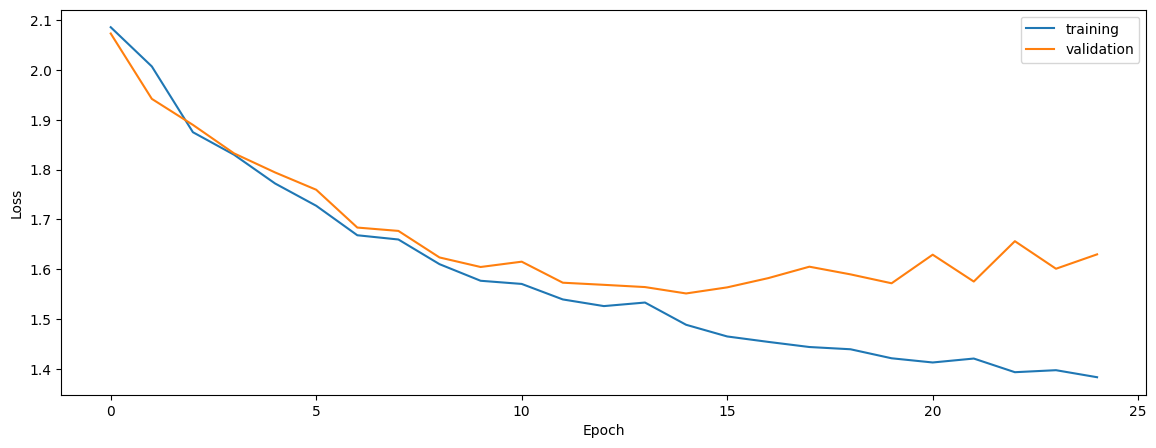

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.42892291182629894


0.38138730407414856


0.35160630946781957


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.3554999815907308


0.33984354582992143


0.2605892110366096


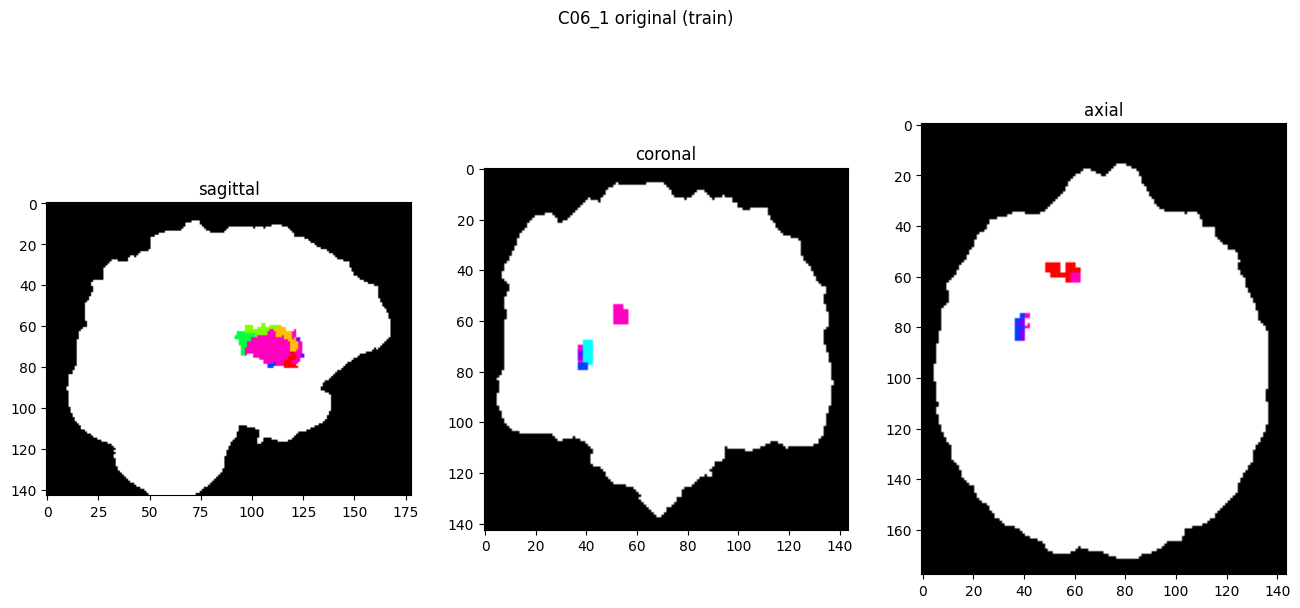

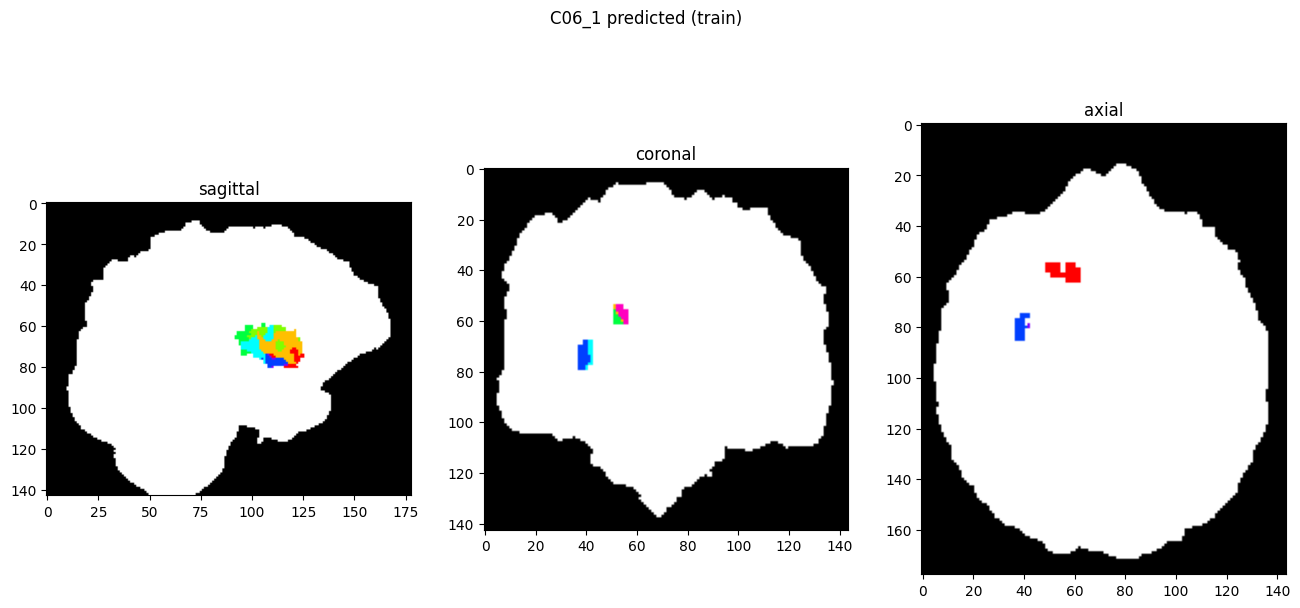

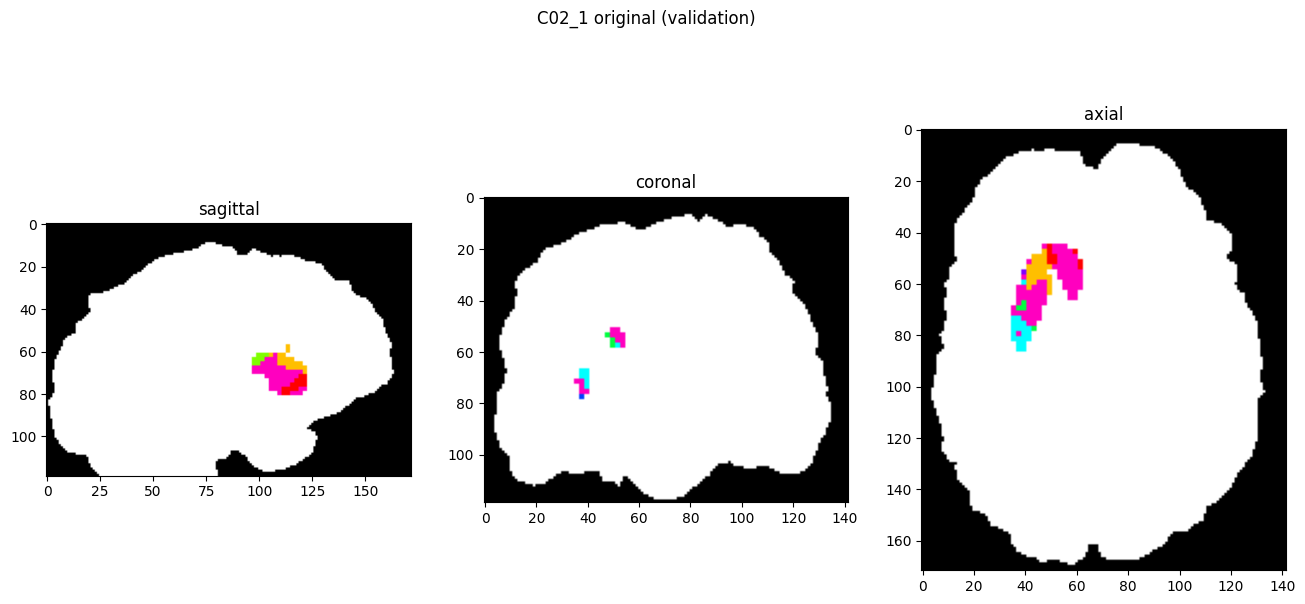

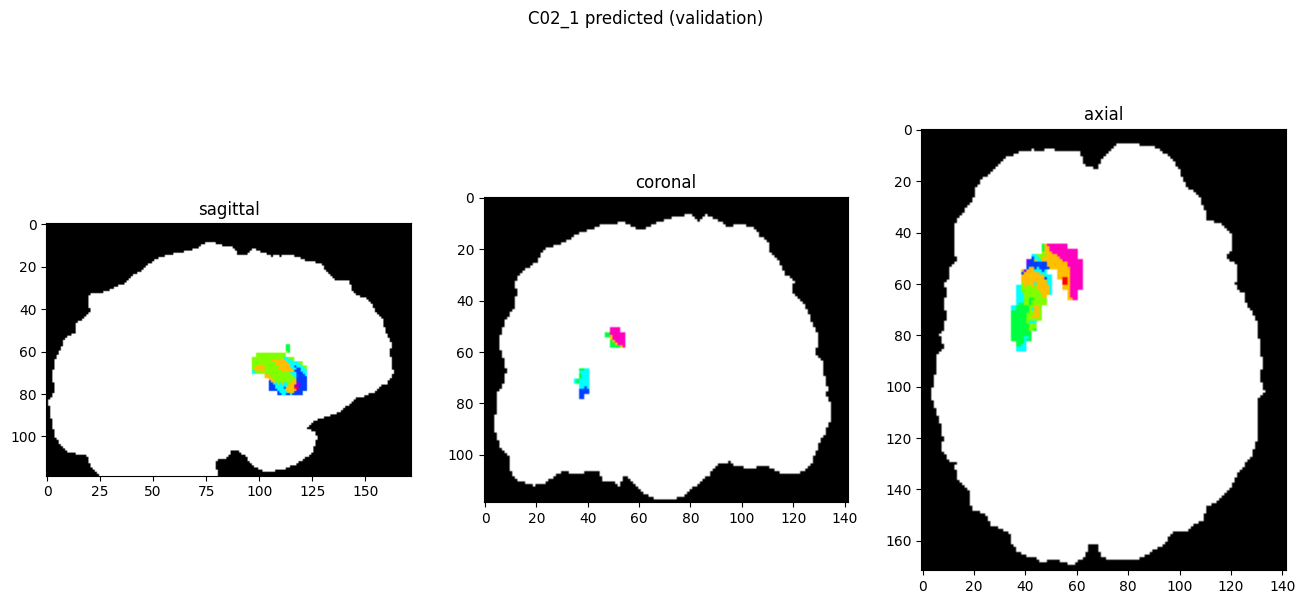

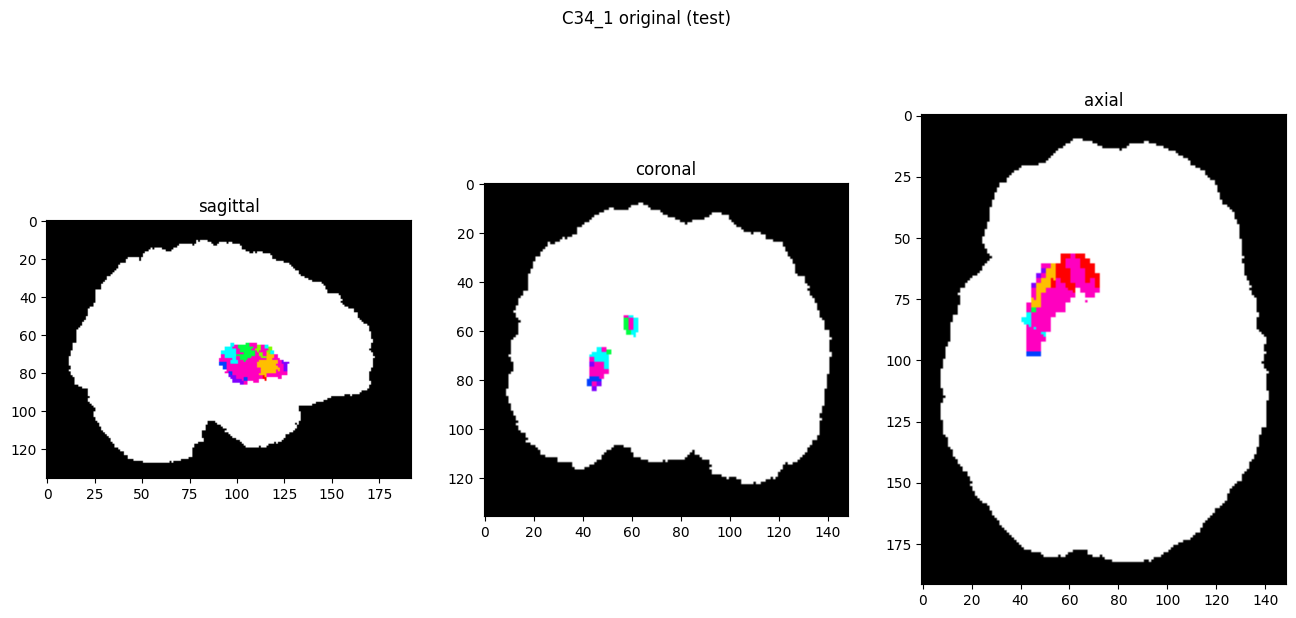

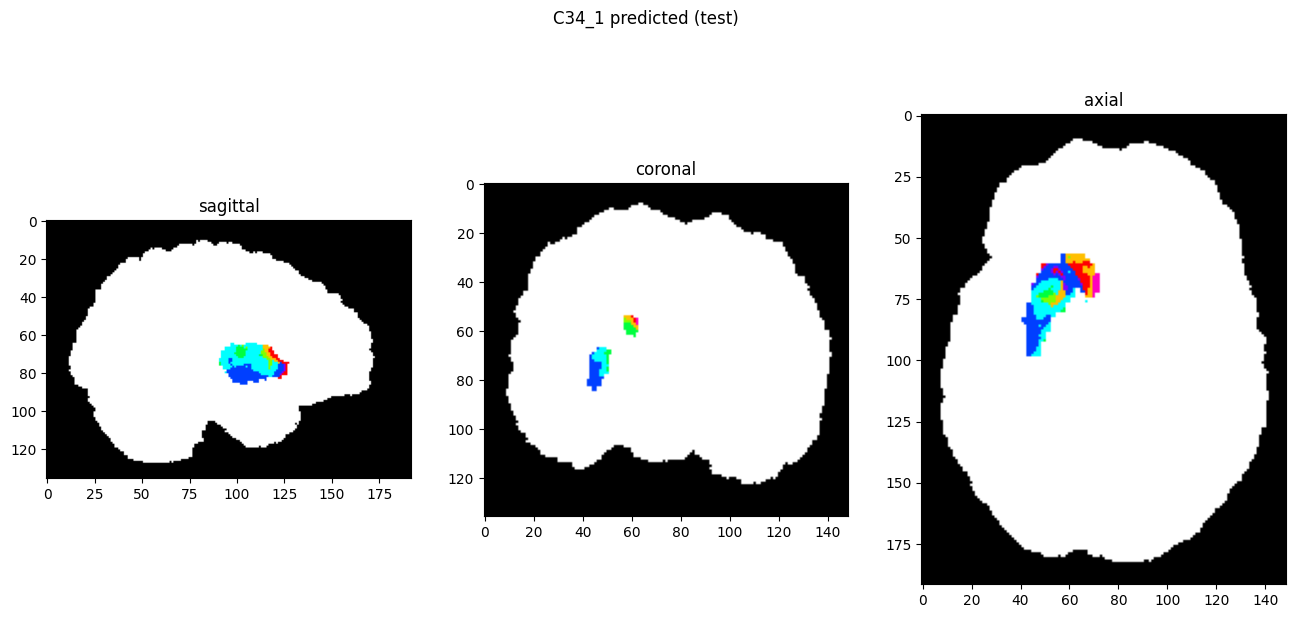

In [9]:
showResults(model, gen, threshold=0)